<a href="https://colab.research.google.com/github/akimotolab/Policy_Optimization_Tutorial/blob/main/2_policy_gradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 準備

まず，必要なパッケージのインストールとインポート，および仮想displayを設定します．

In [1]:
# 必要なパッケージのインストール
!apt update
!pip install swig
!apt install xvfb
!pip install pyvirtualdisplay
!pip install gymnasium[box2d]

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [631 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [1,456 kB]
Hit:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:13 http://archive.ubuntu.com/

In [2]:
from pyvirtualdisplay import Display
import torch

# 仮想ディスプレイの設定
_display = Display(visible=False, size=(1400, 900))
_ = _display.start()

In [3]:
import random
import numpy as np
from scipy.special import softmax
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns
import gymnasium as gym
from IPython import display

続いて，第１回の資料で定義した`rollout`などの基本的な関数をここでも定義しておきます．

In [4]:
def rollout(envname, policy=None, render=False, seed=None):
    if render:
        env = gym.make(envname, render_mode="rgb_array")
    else:
        env = gym.make(envname)
    history = []
    img = []

    # 乱数の設定
    if seed is not None:
        random.seed(int(seed))
    envseed = random.randint(0, 1000)
    actseed = random.randint(0, 1000)
    observation, info = env.reset(seed=envseed)
    env.action_space.seed(actseed)

    # 可視化用の設定
    if render:
        d = Display()
        d.start()
        img.append(env.render())

    # メインループ（環境とのインタラクション）
    terminated = False
    truncated = False
    while not (terminated or truncated):

        # 行動を選択
        if policy is None:
            action = env.action_space.sample()
        else:
            action = policy(observation)

        # 行動を実行
        next_observation, reward, terminated, truncated, info = env.step(action)
        history.append([observation, action, next_observation, reward, terminated, truncated, info])
        observation = next_observation
        if render:
            display.clear_output(wait=True)
            img.append(env.render())
    env.close()
    return history, img


def visualize(img):
    dpi = 72
    interval = 50
    plt.figure(figsize=(img[0].shape[1]/dpi, img[0].shape[0]/dpi), dpi=dpi)
    patch = plt.imshow(img[0])
    plt.axis=('off')
    animate = lambda i: patch.set_data(img[i])
    ani = animation.FuncAnimation(plt.gcf(), animate, frames=len(img), interval=interval)
    display.display(display.HTML(ani.to_jshtml()))
    plt.close()


def cumulative_reward(history):
    return sum(hist[3] for hist in history)

# 方策勾配を用いた方策最適化（強化学習）

今回は「方策勾配法」を見ていきます．
第１回は，汎用的なブラックボックス最適化法を用いた方策最適化の例を見てもらいました．
ブラックボックス最適化法を用いていたということは，目的関数$J(\theta)$が「何らかの方策をパラメータ$\theta$で用いた場合に，環境とインタラクションした結果得られる累積報酬」を意味しているという情報を用いずに，ただブラックボックスな関数として最適化していることを意味します．
ここでは，積極的にこの知識を活用していく方法を検討していきましょう．
ブラックボックス最適化としての方策最適化と，強化学習を用いた方策最適化の一番の違いがここにあります．

## 状態と行動の価値

ブラックボックスな目的関数$J(\theta)$では，一連のインタラクションを通して得られた報酬の合計を評価しています．
これは，最大化したい指標であることに間違いありませんが，一方で，各状態でとった各行動が良かったのかどうか，という情報を与えてくれません．
この情報を活用することができれば，ある状態$s$ではある行動$a$を取るとよい，ということがわかり，その確率を高くするように方策を改善することができそうです．

### 定式化
まず，最低限の定式化を行います．
今回対象としている方策最適化では，
まず初期状態$s_0$を観測します．
初期状態は確率分布$p_0$からランダムに生成されます．
方策を通して，次にとる行動$a_0 \sim \pi(\cdot \mid s_0)$を決定します．
ここでは，方策として確率的な方策を考えることにします．
この行動を実行すると，状態が$s_1$に変わり，これを観測します．
それと同時に，$s_0$で行動$a_0$を取ることの良さを表す即時報酬$r_1$が得られます．
次状態と即時報酬は，環境が定める条件付き確率$p_T(s_1, r_1 \mid s_0, a_0)$により定まります．
このあとは，$s_1$において方策に従って次の行動$a_1 \sim \pi(\cdot \mid s_0)$を決定し，次状態と即時報酬を観測する，というステップを繰り返します．
この環境との一度のインタラクションをステップと呼びます．

注意：「環境が定める」といっても，実際に報酬を設計するのは自分自身（設計者）です．望ましい方策を得るためには，適切な報酬を設計することが極めて重要です．）

### 累積報酬
強化学習においては，方策最適化の目的は割引累積報酬の期待値を最大化することと一般に定められます．
あるステップ$t$において，その先に得られる割引累積報酬は
$$
G_t = r_{t+1} + \gamma r_{t+2} + \dots = \sum_{k=0}^{\infty} \gamma^{k} r_{t+1+k}
$$
と定義されます．ここで，$\gamma \in [0, 1]$は割引率と呼ばれるパラメータです．
方策，初期状態分布，状態遷移，即時報酬は確率的ですから，$G_t$自体も確率的に振る舞います．
そこで，これの期待値$\mathrm{E}[G_0]$を考え，これを最大化することを考えます．

ここでは，インタラクションが無限に続くことを想定して$G_t$が定義されています．
この場合，割引率は$\gamma < 1$であることが必要です．
エピソディックタスクの場合，特別な終了状態（例えば迷路のような問題において，ゴール状態に到達した，落とし穴に落ちて脱落した，など）があり，途中でエピソードが止まることになります．
この場合にも，終了状態に達したあとは何をしても終了状態に遷移し，即時報酬はずっと0である，と考えれば，上の定義に当てはまります．
このように，インタラクションに一区切りがあるようなタスクはエピソディックタスクと呼ばれ，この一区切りのステップのまとまりをエピソードと呼びます．
最適化（学習）の都合上，特定のステップでインタラクションを打ち切り，無理やりエピソディックタスクにするような場合もありますが，この場合にも目的は$\mathrm{E}[G_0]$の最大化である（有限ステップでの累積報酬ではない）と考えると，以下の議論が成立します．

注意：制限時間などのように，特定のステップがすぎると強制的に状態がリセットされるようなケースの場合，注意が必要です．この場合，残り時間などを状態観測に含めることが必要になります．

### 状態価値と行動価値

状態$s$の価値を，「$s_0 = s$からインタラクションを始めて，方策$\pi$に従って行動選択した際に得られる割引累積報酬の期待値$\mathrm{E}[G_0 \mid s_0 = s]$」と定義します．
これを$V^{\pi}(s)$と書きます．
定義からわかるように，状態価値は方策$\pi$に依存しています．
割引累積報酬が
$$
G_{t} = r_{t+1} + \gamma G_{t+1}
$$
という再帰的な関係式を満たすことを考えると，状態価値は
$$
V^{\pi}(s) = \mathrm{E}[r_{1} + \gamma V^{\pi}(s_{1}) \mid s_0 = s]
$$
という関係式を満たすことがわかります．
なお，ステップのインデックスに関しては
$$
V^{\pi}(s) = \mathrm{E}[r_{t+1} + \gamma V^{\pi}(s_{t+1}) \mid s_t = s]
$$
と考えても構いません．
状態の価値が高いということは，その方策に従っている場合には，その状態からは得られる割引累積報酬の期待値が高いということを意味しています．
ですから，そのような状態を積極的に訪問したいという指針になるでしょう．

関連して，行動価値（状態行動価値とも言います）を，「$s_0 = s$からインタラクションを始めて，最初だけ行動$a$を選択し，その後は方策$\pi$に従って行動選択した際に得られる割引累積報酬の期待値$\mathrm{E}[G_0 \mid s_0 = s, a_0 = a]$」と定義します．
これを$Q^{\pi}(s, a)$と書きます．
定義からわかるように，もしも最初の行動を$a \sim \pi(\cdot \mid s)$にしたがって決定していれば行動価値関数の$a \sim \pi(\cdot \mid s)$についての期待値は，状態$s$の価値
$$
V^\pi(s) = \mathrm{E}[Q^{\pi}(s, a) \mid a \sim \pi(\cdot \mid s)]
$$
に一致します．

価値関数はいずれも解析的に得られるものではありません．
しかし，インタラクションを通して，近似していくことが可能です．
その代表的な方法の一つに，TD誤差を用いた更新があります．

## 方策勾配

目的関数を数値的に最適化する際，まず考えられる方針は勾配法を用いることです．
すなわち，$\theta \leftarrow \theta + \alpha_\theta \nabla_\theta J(\theta)$と更新する方法です．
割引累積報酬をブラックボックスと捉えてしまうと勾配は計算できないのですが，価値関数を明示的に使うことで勾配をうまく近似することが可能です．
「方策勾配定理」は，割引累積報酬の期待値の，方策パラメータについての期待値を書き下す方法を提供してくれます．

### 方策勾配定理

$J(\theta) = \mathrm{E}[V^{\pi}(s) \mid s \sim p_0]$とします．
このとき，
$$
\nabla_\theta J(\theta) \propto \mathrm{E}\left[ Q^{\pi}(s, a) \nabla_{\theta} \ln \pi_\theta(a \mid s)  \right]
$$
と書き下すことができます．
ここで，上の期待値は，方策$\pi_\theta$のもとでの状態訪問確率と行動選択確率について取られています．
実際にインタラクションを通して観測された状態とその状態のもとで方策$\pi_\theta$に従って選択された行動を用いれば，右辺は
$$
Q^{\pi}(s_t, a_t) \nabla_{\theta} \ln \pi_\theta(a_t \mid s_t)
$$
で近似することができます．
また，行動価値関数をその近似値$q(s_t, a_t)$で置き換えれば，勾配$\nabla_\theta J(\theta)$の推定値として
$$
q(s_t, a_t) \nabla_{\theta} \ln \pi_\theta(a_t \mid s_t)
$$
を得ることができます．
もしくは，1エピソード分の状態遷移履歴を用いて，
$$
\frac{1}{T}\sum_{t=0}^{T} q(s_t, a_t) \nabla_{\theta} \ln \pi_\theta(a_t \mid s_t)
$$
と近似することができます．
これらを用いて，
$$
\theta \leftarrow \theta + \alpha_\theta \frac{1}{T}\sum_{t=0}^{T} q(s_t, a_t) \nabla_{\theta} \ln \pi_\theta(a_t \mid s_t)
$$
などと方策パラメータを更新していきます．ここで，$\alpha_\theta$は学習率です．




### 方策勾配の自動計算

方策勾配を計算するには，方策の対数の方策パラメータについての勾配 $\nabla_\theta \ln \pi$ を求める必要があります．
方策を変える毎に，これを計算して実行するのは，複雑な方策を採用する際には面倒になります．
他方，深層学習で用いられている Pytorch などのライブラリでは，関数の勾配を自動的に計算してくれる機能が備わっています．この機能を活用することで，方策勾配も容易に計算することが可能になります．

上に示した1エピソード分のデータを用いた方策勾配
$$
\frac{1}{T}\sum_{t=0}^{T} q(s_t, a_t) \nabla_{\theta} \ln \pi_\theta(a_t \mid s_t)
$$
を計算したい状況を考えましょう．
いま，$q^{\pi}(s_t, a_t)$は何らかの方法（後述します）で予め計算されているとします．
このとき，以下のような関数を考えます．
$$
L(\theta; \{(s_t, a_t)\}_{t=0}^{T}) = \frac{1}{T}\sum_{t=0}^{T} q(s_t, a_t) \ln \pi_\theta(a_t \mid s_t)
$$
このような関数$L$を定義すると，上に示した方策勾配は $\nabla_\theta L(\theta; \{(s_t, a_t)\}_{t=0}^{T})$ であることが容易にわかります．

この事実を用いると，方策勾配を自動計算することが可能になります．
行動が離散であれば，各行動の選択確率からなるベクトルを返す関数モデルを用意しておけば，用意に計算できます．

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Categorical

# gpuが使用される場合の設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu" )

以下では，Pytorchを用いた方策（ここではActorと呼ぶことにします．これは今後紹介するActor-Criticアルゴリズムでの呼び方に従っています．）の実装方法を紹介します．
ここでは四層のニューラルネットワークを用いています．中間層のノード数は`dim_hidden`により指定されています．

関数`forward`が観測`x`を受け取って，これに対して各行動の選択確率を出力する関数です．
行動選択確率は以下のように計算されます．
入力を$h_0 = x$とします．
$i = 1, 2, 3, 4$について，以下を計算します．
$$
h_i = g_i\left( b_i + W_i h_{i=1}\right)
$$
ここで，中間層の活性化関数$g_1, g_2, g_3$は$\mathrm{ReLU}(s) = \max(0, s)$であり，
出力部分の活性化関数$g_4$は出力の和が$1$となるように，$\mathrm{softmax}$を用いています．

In [7]:
class Actor(nn.Module):
    def __init__(self, dim_state, num_action, dim_hidden=16):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(dim_state, dim_hidden)
        self.fc2 = nn.Linear(dim_hidden, dim_hidden)
        self.fc3 = nn.Linear(dim_hidden, dim_hidden)
        self.fc4 = nn.Linear(dim_hidden, num_action)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.softmax(self.fc4(x), dim=0)
        return x

実行時間の観点から，簡易化した２層のモデルを以下の実験では使うことにします．

In [8]:
class Actor(nn.Module):
    def __init__(self, dim_state, num_action, dim_hidden=128):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(dim_state, dim_hidden)
        self.fc2 = nn.Linear(dim_hidden, num_action)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=0)
        return x

## REINFORCEアルゴリズム（行動価値関数のMonte Carlo推定を用いた方策勾配法）

方策勾配を用いた強化学習の代表的な一つの方法である，REINFORCEアルゴリズムを紹介します．
話を簡単にするために，ここでは

1. エピソディックタスク，
2. 割引率$\gamma = 1$（割引なし），
3. 確率的方策，

であることを仮定します．

方策勾配法を用いる場合，行動価値関数$Q^{\pi}(s_t, a_t)$の近似値$q(s_t, a_t)$を得ることが必要になります．
この$q(s_t, a_t)$の計算方法の違いにより，様々な方策勾配法のバリエーションが存在します．
REINFORCEアルゴリズムでは，Monte-Carlo推定を用いてこれを近似して利用します．

### 行動価値関数のモンテカルロ推定

行動価値関数$Q^{\pi}(s, a)$は「$s_0 = s$からインタラクションを始めて，最初だけ行動$a$を選択し，その後は方策$\pi$に従って行動選択した際に得られる割引累積報酬の期待値$\mathrm{E}[G_0 \mid s_0 = s, a_0 = a]$」と定義されます．
すなわち，この期待値は各ステップ$t$での状態の訪問確率と行動の選択確率を知らなければ計算できません．
行動の選択確率は方策で決まりますから，これは予め知っている情報ですが，ある状態である行動を取った際の次の状態への遷移確率は未知である（実際に実行して始めて次状態を観測できる）と仮定していますから，これを計算することはできません．
期待値を厳密には計算できませんが，実際にインタラクションを通して累積報酬の実現値を観測することは可能です．
これを用いて期待値を推定する方法がモンテカルロ推定です．

状態遷移はステップ数$t$には依存しないため，行動価値関数$Q^{\pi}(s, a)$は$\mathrm{E}[G_t \mid s_t = s, a_t = a]$と定義しても同じものになります．
すなわち，ステップ$t$において観測した状態が$s_t = s$，$a_t = a$であったならば，そこから実際にインタラクションして得られた累積報酬 $G_t = r_{t+1} + \dots + r_{T}$（$T$は終端ステップ）の期待値がその$(s_t, a_t)$の行動価値であり，観測された$G_t$は確率変数として見た場合の$G_t$の観測値（サンプル）であることがわかります．
そのため，観測された$G_t$は行動価値$Q^\pi(s_t, a_t)$の不偏推定値であることになります．
そこで，これを$q^\pi(s_t, a_t)$として採用することにしましょう．


実装上は，1エピソードの結果得られる状態遷移履歴から，各ステップでの将来に得られる累積報酬を計算し，その配列を返します．
終了状態から遡ることで計算することでこれを簡単に計算できます．

### REINFORCEアルゴリズム

REINFORCEアルゴリズムは，価値のモンテカルロ推定を用いた方策勾配法です．
REINFORCEにはいくつかのバリエーションがありますが，ここでは，エピソード単位で方策パラメータを更新する最もシンプルな方法を紹介します．
（なお，状態遷移毎（ステップ毎）にパラメータを更新するバリエーションもあります．）

まず，現在の方策を用いてEエピソード分だけ環境とインタラクションします．
この結果から，エピソード内に訪問した各状態についての価値をモンテカルロ推定します．
この推定価値を用いて，方策勾配を
$$\begin{aligned}
\nabla_\theta J(\theta)
&= \mathrm{E}\left[ Q^{\pi}(s, a) \nabla_{\theta} \ln \pi(a \mid s)  \right] \\
&\approx \frac{1}{E}\sum_{e=1}^{E}\frac{1}{T_e}\sum_{t=1}^{T_e} G_{e,t} \nabla_{\theta} \ln \pi(a_{e,t} \mid s_{e,t}) =: \widehat{\nabla_\theta J(\theta) }
\end{aligned}
$$
と近似し，方策パラメータを$\theta \leftarrow \theta + \eta \widehat{\nabla_\theta J(\theta) }$に従って更新します．
ここで，$\eta > 0$は学習率を表し，問題や方策毎に調整が必要となります．
また，状態，行動，累積報酬にはエピソードのインデックスが追加されており，終了ステップもエピソード毎に異なることに注意してください．

以下では，REINFORCEアルゴリズムを実装しています．

`select_action`は状態観測を受け取り，方策に従って行動を選択しています．
実装上は，観測状態をPytorchのテンソル形式に変換し，これをActorに入力して行動確率確率を計算し，これに従って行動をサンプルしています．
パラメータを更新する際に必要になる$\ln \pi(a \mid s)$も出力しています．

`rollout`は現在の方策を用いて1エピソード分，環境と状態遷移を繰り返し，その際の即時報酬列と$\ln \pi(a \mid s)$列を返します．

`update`はActorのパラメータを更新する関数です．
ここでは，エピソード数は$E = 1$を前提としています．
確率的傾斜法の理屈から，$E$を大きくして方策勾配の分散を小さくすることと，学習率$\eta$を小さくしてパラメータ更新の分散を小さくすることには類似の効果があることが知られています．
そのため，以下の議論では主に$E = 1$を前提としていきます．



In [28]:
class ReinforceAgent:
    def __init__(self, env, model, device, lr):
        self.device = device
        self.policy = model
        self.env = env
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr, betas=(0.9, 0.999))

    def __call__(self, observation):
        return self.select_action(observation)[0]

    def select_action(self, observation):
        # 行動選択
        observation_ = Variable(torch.Tensor(observation)).to(self.device)
        action_probs = self.policy(observation_)
        log_probs = action_probs.log()
        action = Categorical(action_probs).sample()
        return action.data.cpu().numpy(), log_probs[action]

    def rollout(self):
        # 1 エピソード実行
        observation, info = self.env.reset()
        steps = 0
        rewards = []
        log_probs = []
        terminated = False
        truncated = False
        while not (terminated or truncated):
            action, log_prob = self.select_action(observation)
            next_observation, reward, terminated, truncated, info = self.env.step(action)
            log_probs.append(log_prob)
            rewards.append(reward)
            observation = next_observation
            steps +=1
        return rewards, log_probs

    def update(self, rewards, log_probs):
        # パラメータの更新
        g_array = np.cumsum(np.array(rewards)[::-1])[::-1]
        loss = - sum([g * lp for g, lp in zip(g_array, log_probs)]) / len(rewards)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

`LunarLander-v2`環境で，REINFORCEアルゴリズムによる学習を実行してみます．
比較的時間がかかりますので，注意してください．（30min程度）

In [33]:
envname = "LunarLander-v2"
dim_state = 8
num_action = 4
env = gym.make(envname)

model = Actor(dim_state = 8, num_action = 4).to(device)
agent = ReinforceAgent(env, model, device, lr=1e-4)

ここでは，100エピソード毎に学習された方策を用いて得られる累積報酬の平均値と標準偏差を表示しています．

In [ ]:
interval = 100
returns = np.zeros((100, interval))

for i in range(returns.shape[0]):
    for j in range(returns.shape[1]):
        rewards, log_probs = agent.rollout()
        agent.update(rewards, log_probs)
        returns[i, j] = np.sum(rewards)
    print(interval * (i+1), np.mean(returns[i]), np.std(returns[i]))

100 -215.55651266291977 125.18010552537586
200 -177.62536831290655 99.22229716939289
300 -199.17520398673415 108.76910168503156
400 -160.8052318534324 92.27953504077163
500 -197.2215528199149 108.22883591168464
600 -179.29943967518935 93.37064761185098
700 -177.12723637717448 111.9778074426303
800 -187.25367595224714 109.64336606831283
900 -174.51918943066713 99.83690558575242
1000 -146.85939729516952 82.28843298370856
1100 -163.17519892089646 98.12431543981401
1200 -175.7809211201302 112.07418567628748
1300 -176.16724903976817 92.6623429550487
1400 -160.11058303164845 95.86116049740542
1500 -154.8231618971021 88.1576602043093
1600 -191.5976697876359 104.27725837380167
1700 -165.89567506219464 93.9511310690935
1800 -155.4223498927815 81.39673053820279
1900 -158.37590138059204 80.75541286686969
2000 -163.18290077456018 85.33790299300009
2100 -160.56633851190475 103.18161561901053
2200 -154.44542435142077 79.02044495157658
2300 -137.09678479763733 88.09374563411565
2400 -139.110650559769

累積報酬の移り変わりを可視化してみます．累積報酬の平均値は改善していく様子が見られると思います．ただ，比較的標準偏差が大きいことが確認できるでしょう．

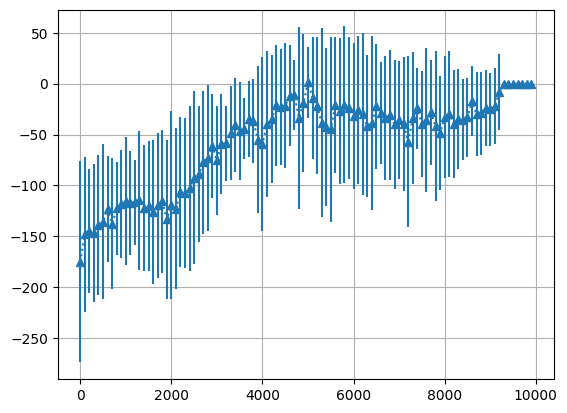

In [10]:
episodes = np.arange(1, 1+returns.size, returns.shape[1])
avg = np.mean(returns, axis=1)
std = np.std(returns, axis=1)
plt.errorbar(episodes, avg, std, linestyle=':', marker='^')
plt.grid()

学習後の経験分布関数を確認してみましょう．
横軸は累積報酬を$-1$倍したものになりますので，小さい値が高い割合で得られるほど，望ましい方策が得られていると言えるでしょう．

In [ ]:
return_array = np.zeros(50)
for i in range(len(return_array)):
    history, img = rollout(envname, policy=agent, render=False)
    return_array[i] = cumulative_reward(history)

fig, ax = plt.subplots()
sns.ecdfplot(data=-return_array, ax=ax)
ax.set_xlim(-400, 400)
plt.grid()

それでは学習結果を確認してみましょう．
累積報酬の標準偏差が比較的大きいことが予想されますので，何度か実行し，確認してみましょう．

In [ ]:
history, img = rollout(envname, policy=agent, render=True)
print(cumulative_reward(history))
visualize(img)

前回のブラックボックス最適化法を用いた方策最適化に対して，方策勾配法は累積報酬だけでなく状態遷移の履歴を活用した方策最適化法になっています．しかし，あまり効率的になっている印象は持てないかもしれません．
実際には方策モデルが異なるため今回の実験からは実行時間の比較ができません．
また，強化学習では「期待累積報酬」を最大化しており，特定の乱数系列（特定の初期状態）のもとでの累積報酬最適化を行っていた前回の結果と比較するのはフェアではありません．

ただ，上記のREINFORCEが効率的でないことも事実です．
一つの原因として，「方策勾配は推定分散が大きい」ことが挙げられます．
REINFORCEでは，エピソード中に得られた累積報酬を用いて価値関数を近似し，これを用いて方策勾配を近似しています．
しかし，実行結果を見てもわかるように，累積報酬の値は大きな分散を持っているため，これを用いて推定される方策勾配も大きな分散を持ってしまいます．
方策勾配の分散が大きい場合，これに伴って学習率を小さくしなければならず，学習が遅くなります．

## ベースラインの導入による方策勾配の推定分散削減

方策勾配の推定分散を削減するために，方策勾配の式を見直してみましょう．
方策勾配は以下の式を近似しています．
$$
\begin{aligned}
&\mathrm{E}\left[ Q^{\pi}(s, a) \nabla_{\theta} \ln \pi_\theta(a \mid s)  \right]
\\
&= \mathrm{E}_s \mathrm{E}_a \left[ Q^{\pi}(s, a) \nabla_{\theta} \ln \pi_\theta(a \mid s)  \right]
\\
&= \mathrm{E}_s \left[ \sum_{a} Q^{\pi}(s, a) \pi_\theta(a \mid s)  \nabla_{\theta} \ln \pi_\theta(a \mid s)  \right]
\\
&= \mathrm{E}_s \left[ \sum_{a} Q^{\pi}(s, a) \nabla_{\theta} \pi_\theta(a \mid s)  \right]
\end{aligned}
$$
この式を修正してみます．まず，ある関数$b(s)$について，
$$
\sum_{a} b(s) \nabla_{\theta} \pi_\theta(a \mid s)
=
b(s) \sum_{a} \nabla_{\theta} \pi_\theta(a \mid s)
=
b(s) \nabla_{\theta} \sum_{a} \pi_\theta(a \mid s)
=
b(s) \nabla_{\theta} 1
= 0
$$
が成り立つことに注意すれば，上の式は，
$$\begin{aligned}
\mathrm{E}\left[ Q^{\pi}(s, a) \nabla_{\theta} \ln \pi_\theta(a \mid s)  \right]
&= \mathrm{E}_s \left[ \sum_{a} \left( Q^{\pi}(s, a) - b(s) \right) \nabla_{\theta} \pi_\theta(a \mid s)  \right]
\\
&= \mathrm{E}_{s,a} \left[ \left( Q^{\pi}(s, a) - b(s) \right) \nabla_{\theta} \ln \pi_\theta(a \mid s)  \right]
\end{aligned}
$$
と書き直すことができることがわかると思います．
すなわち，行動価値関数$Q^{\pi}(s, a)$から，状態のみに依存する任意の関数$b(s)$を引いたとしても，この期待値は変化しないことがわかります．
しかし，これを推定する場合，
$$
\left( q(s, a) - b(s) \right) \nabla_{\theta} \ln \pi_\theta(a \mid s)
$$
の期待値は上の議論から代わりませんが，その推定分散は$b(s)$に依存することになります．
そこで，この$b(s)$を工夫することで，推定量分散を小さくする試みがあります．

代表的な$b(s)$の選択肢は，行動価値関数の行動についての期待値，すなわち状態価値関数です．
行動価値から状態価値を引いた値はアドバンテージなどと呼ばれ，しばしば強化学習の文脈で現れる量になります．
状態価値をベースラインとして利用することは，必ずしも最適ではありませんが，合理的と考えられる理由があります．これについて簡単に考察してみましょう．
まず，$\nabla \ln \pi(a \mid s)$に着目します．
これは，$\ln \pi(a \mid s)$の勾配ですから，状態$s$で行動$a$を選択する確率が上昇する方向にパラメータが更新されます．
上のREINFORCEでは，エピソード中に実際に観測した状態$s_t$とそこで選択された行動$a_t$について，$\ln \pi(a_t \mid s_t)$に累積報酬を乗じた方向にパラメータが更新されています．
ここで，Lunar-Landerの例に着目すると，エピソード中を通してほとんどの場合に累積報酬が負の値になっていることがわかると思います．
このとき，どのような行動を取ったとしても，選択された行動の選択確率を下げる方向にパラメータは更新されることになります．
これでは効率が悪い更新になっていると想像されます．
期待値を累積報酬から減ずることにより，その状態で得られる累積報酬の期待値よりも高い価値を持つ行動については行動選択確率を上げ，逆に価値の低い行動については行動選択確率を下げる，といった更新が可能になります．
（なお，常に行動選択確率を下げるにもかかわらず方策が収束していくのは，その下げ幅が報酬の大小関係により異なるため，長い目でみれば報酬の高い行動の選択確率が相対的に上がることになるためである）



### ベースラインを導入したREINFORCEアルゴリズム

それでは状態価値をベースラインとしたREINFORCEアルゴリズムを実装してみましょう．
追加で必要なコンポーネントは，状態価値の推定部分です．
状態価値は，各状態でその先に得られる累積報酬の期待値で与えられます．
そこで，状態価値を近似する関数モデルを$b_\phi(s)$としたとき，1エピソード中の状態遷移履歴を用いて，
$$
L(\phi) = \frac{1}{T}\sum_{t=1}^{T} (G_t - b_{\phi}(s_{t-1}))^2
$$
を最小化するように$\phi$を学習することが考えられます．

以下では，ベースラインを計算するネットワークを作成しています．
ここでもActor-Criticにならい，ベースラインをCriticと呼ぶことにします．

CriticのアーキテクチャはActorと同様とします．
異なる点は，出力が1次元であり，出力には活性化関数を設けないという点です．

In [ ]:
class Critic(nn.Module):
    def __init__(self, dim_state, dim_hidden=128):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(dim_state, dim_hidden)
        self.fc2 = nn.Linear(dim_hidden, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

ベースラインを導入したREINFORCEアルゴリズムを実装します．
`update`関数において，criticを更新している点が前述のREINFORCEとの差分です．

In [ ]:
class ReinforceBaselineAgent:
    def __init__(self, env, actor, critic, device, lr_a, lr_c):
        self.device = device
        self.actor = actor
        self.critic = critic
        self.env = env
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr_a)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr_c)

    def __call__(self, observation):
        return self.select_action(observation)[0]

    def select_action(self, observation):
        # 行動選択
        observation_ = Variable(torch.Tensor(observation)).to(self.device)
        action_probs = self.actor(observation_)
        log_probs = action_probs.log()
        action = Categorical(action_probs).sample()
        return action.data.cpu().numpy(), log_probs[action]

    def rollout(self):
        # 1 エピソード実行
        observation, info = self.env.reset()
        steps = 0
        rewards = []
        log_probs = []
        states = []
        terminated = False
        truncated = False
        while not (terminated or truncated):
            action, log_prob = self.select_action(observation)
            next_observation, reward, terminated, truncated, info = self.env.step(action)
            log_probs.append(log_prob)
            rewards.append(reward)
            states.append(observation)
            observation = next_observation
            steps +=1
        return rewards, log_probs, states

    def update(self, rewards, log_probs, states):
        g_array = np.cumsum(np.array(rewards)[::-1])[::-1]
        b_list = [self.critic(torch.Tensor(s).to(device)).cpu() for s in states]
        # Actor の更新
        b_array = torch.cat(b_list, dim=0).detach().numpy()
        g_array = g_array - b_array
        loss_a = - sum([g * lp for g, lp in zip(g_array, log_probs)]) / len(rewards)
        self.actor_optimizer.zero_grad()
        loss_a.backward()
        self.actor_optimizer.step()
        # Critic の更新
        loss_c = sum([(b - g)**2 for g, b in zip(g_array, b_list)]) / len(states)
        self.critic_optimizer.zero_grad()
        loss_c.backward()
        self.critic_optimizer.step()


In [ ]:
envname = "LunarLander-v2"
dim_state = 8
num_action = 4
env = gym.make(envname)

actor2 = Actor(dim_state = 8, num_action = 4).to(device)
critic2 = Critic(dim_state = 8).to(device)
agent2 = ReinforceBaselineAgent(env, actor2, critic2, device, lr_a=1e-4, lr_c=1e-4)

In [ ]:
interval = 100
returns2 = np.zeros((100, interval))

for i in range(returns2.shape[0]):
    for j in range(returns2.shape[1]):
        rewards, log_probs, states = agent2.rollout()
        agent2.update(rewards, log_probs, states)
        returns2[i, j] = np.sum(rewards)
    print(interval * (i+1), np.mean(returns2[i]), np.std(returns2[i]))

ベースラインの有無による学習曲線の差を可視化してみましょう．
比較のため，Actorの学習率をそろえていますが，ベースラインの導入により，方策勾配の分散が削減されるので，少し大きめの学習率を設定することも可能になり，その結果として高速化することも可能になると期待されます．
ただ，一方で，ActorとCriticの学習率の両方を調整することが必要となるため，パラメータ調整が実用上は面倒になりえることは述べておきます．

[*重要*]
ここで比較しているアプローチは，学習結果が乱数に依存します．そのため，本来一試行の結果を比較するというのは適切ではありません．偶然偏った結果が得られている可能性があるからです．例えば平均性能を比較したければ，複数試行学習を実施し，平均や標準偏差，もしくは中央値と四分位範囲，を可視化して比較するなどしましょう．

In [ ]:
episodes = np.arange(1, 1+returns.size, returns.shape[1])
avg1 = np.mean(returns, axis=1)
std1 = np.std(returns, axis=1)
plt.errorbar(episodes, avg1, std1, linestyle=':', marker='^')
avg2 = np.mean(returns2, axis=1)
std2 = np.std(returns2, axis=1)
plt.errorbar(episodes, avg2, std2, linestyle=':', marker='v')
plt.grid()

経験分布関数についても確認しておきましょう．

In [ ]:
return_array = np.zeros(50)
for i in range(len(return_array)):
    history, img = rollout(envname, policy=agent2, render=False)
    return_array[i] = cumulative_reward(history)

fig, ax = plt.subplots()
sns.ecdfplot(data=-return_array, ax=ax)
ax.set_xlim(-400, 400)
plt.grid()

学習結果の確認は以下のコードで行います．

In [ ]:
history, img = rollout(envname, policy=agent2, render=True)
print(cumulative_reward(history))
visualize(img)

# 自習課題

* 方策を変えてみましょう．特に，中間層のノード数を変更した場合に，学習効率がどの程度変わるのか，グラフを作成するなどして確認しましょう．

* 学習率を調整してみましょう．特に，ベースラインを導入したREINFORCEでは，Actorの学習率とCriticの学習率について，効率的なパラメータの関係を確認してみましょう．

* タスクを変えてみましょう．タスクが異なれば，適切な方策（ノード数など）や適切な学習率も変化する可能性があります．これを確認してみましょう．